In [12]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
from astropy.time import Time
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from photutils import CircularAperture, aperture_photometry
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm_notebook

plt.rcParams['axes.linewidth']=3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rc('xtick.major', size=8, pad=8)
plt.rc('xtick.minor', size=6, pad=5)
plt.rc('ytick.major', size=8, pad=8)
plt.rc('ytick.minor', size=6, pad=5)
plt.rcParams['font.size'] = 18


parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

In [2]:
def feature_tab(element):

    files = np.sort([i for i in os.listdir('.') if i.endswith(element)])[1:]

    tab = Table()
    limb_vals = np.array([], dtype='U10')

    for i in tqdm_notebook(range(len(files))):
        dat = np.loadtxt(files[i])
        if len(dat) > 0:
        
            val = files[i].split('.')[0][-3:]

            key = 'limb_' + val

            if i == 0:
                tab.add_column(Column(dat[:,0], 'wavelength'))

            if len(dat[:,1]) == 55006 and element=='halpha':
                tab.add_column(Column(dat[:,1], key))
                limb_vals = np.append(limb_vals, val)
            elif len(dat[:,1]) == 115000 and element=='calcium':
                tab.add_column(Column(dat[:,1], key))
                limb_vals = np.append(limb_vals, val)
    
    return tab, limb_vals

In [3]:
def feature_region(tab, wstart, wstop):
    return tab[(tab['wavelength']>=wstart) & 
               (tab['wavelength']<=wstop)]

In [4]:
def discrete_star(res, limb_vals):

    x = np.linspace(-1.0, 1.0, res)
    y = np.linspace(-1.0, 1.0, res)

    z = np.ones(res**2).reshape(res,res)

    xx, yy = np.meshgrid(x, y, sparse=True)

    r = np.sqrt(xx**2 + yy**2)
    z[r >1] = 0

    lat = np.arcsin(yy)
    lon = np.arcsin(xx)

    v_diffrot = 100*z*np.cos(lat)*np.sin(lon) *np.cos(lat/1.0)
    v = 100*z*np.cos(lat)*np.sin(lon)

    limb = 1.0*(1-0.64*(1-np.cos(r*np.pi/2)))
    limb[r>1] = 0

    discrete_limb = np.zeros(limb.shape)

    for i in range(len(limb_vals)-1):
        discrete_limb[(limb >= float(limb_vals[i])) & 
                      (limb <  float(limb_vals[i+1]))] = float(limb_vals[i])
        
    return discrete_limb

In [8]:
tab, limb_vals = feature_tab(element='calcium')
limb_vals = np.sort([int(i)/100 for i in limb_vals])
#tab = feature_region(tab, 8494, 8510)
#tab = feature_region(tab, 6560, 6566)

In [ ]:
tab[0]['wavelength'], tab[-1]['wavelength']

In [ ]:
plt.plot(tab['wavelength'], tab['limb_010'])
plt.xlim(8493, 8503)
plt.ylim(0.4,1.0)
tab = feature_region(tab, 8493, 8503)

In [ ]:
rstar_pixel = 20001

discrete_limb = discrete_star(rstar_pixel, limb_vals)

# up the resolution of the spectra

In [ ]:
rstar = discrete_limb.shape[0]/2.0
astar = np.pi * rstar**2

rplanet = 0.0300  * rstar
aplanet = np.pi * rplanet**2

psize = aplanet/astar * discrete_limb.shape[0] # radius of planet in pixel space
psize = np.ceil(psize)
psize

In [ ]:
# Takes a slice of the star at the equator
sliced = discrete_limb[int(rstar_pixel/2)-1:int(rstar_pixel/2), :int(rstar_pixel/2)] + 0.0
sliced = np.reshape(sliced, sliced.shape[1])
sliced.shape

In [ ]:
def create_features(dat, planetsize):

    unique_vals = np.unique(dat)
    areas = np.zeros(len(unique_vals))
    for i in range(len(unique_vals)):
        where = np.where(np.flip(dat)==unique_vals[i])[0] 
        areas[i] = np.pi * (np.nanmax(where)**2 - np.nanmin(where)**2)
    
    spec_timesteps = np.zeros((len(dat)+19, len(tab)))

    for i in tqdm_notebook(range(len(dat)+19)):

        mask = np.zeros(dat.shape)

        if i < psize:
            start = 0
            end = i
        else:
            start = int(i-planetsize/2)-8
            end = int(i+planetsize/2+1)-10

        if start < 0:
            start = 0

        if end > len(dat):
            end = len(dat)
        mask[start:end] = 1

        # Applies mask
        q = mask == 0
        masked_slice = dat[q]

        weights = np.zeros(len(unique_vals))

        # Gets weights per each limb darkening value
        # Multiplies by area of ring for that limb darkening val
        for u in range(len(unique_vals)):
            where = np.where(masked_slice==unique_vals[u])[0]
            weights[u] = len(where) * areas[u]

        # Normalizes weights
        weights = weights/ np.nansum(weights)

        spec = np.zeros(len(tab))

        # Adds together spectra multiplied by appropriate weight
        for u in range(len(weights)):
            spec += (tab[tab.colnames[u+8]] * weights[u])
        spec_timesteps[i] = spec

    return spec_timesteps, unique_vals, areas, weights

In [ ]:
spec_timesteps, unique_vals, areas, weights = create_features(sliced, psize)

In [ ]:
template_weights = np.zeros(len(unique_vals))
for u in range(len(unique_vals)):
    where = np.where(sliced==unique_vals[u])[0]
    template_weights[u] = len(where) * areas[u]
template_weights = template_weights/np.nansum(template_weights)

template = np.zeros(len(tab))
    
for u in range(len(weights)):
    template += (tab[tab.colnames[u+8]] * template_weights[u])

In [ ]:
diff = np.rot90((spec_timesteps-template))*10**4

plt.imshow( diff[1000:4000,:], cmap='seismic', vmin=-0.4, vmax=0.4)
plt.colorbar(label='diff x $10^{4}$')
plt.xlabel('"time"')
plt.ylabel('spectrum - template')
#plt.xlim(0,40)
#plt.ylim(1400,1800)
#plt.savefig('/Users/arcticfox/Desktop/by_ring_highres_calcium_zoomin.png',
#            rasterize=True, bbox_inches='tight', dpi=250)

# Paper plot

In [9]:
from pylab import *
colormap='YlOrRd_r'

cmap = cm.get_cmap(colormap, 20)

colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb


clist = ['#000000', colors[5], colors[10]]

rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)


colors = []
for i in range(cm.N):
    rgb = cm(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

colors = np.unique(colors)
colors = colors[np.linspace(0,len(colors)-1,len(tab.colnames)-8,dtype=int)]

In [10]:
plotting_limb_0 = discrete_star(3001, limb_vals)

plotting_limb = np.full(plotting_limb_0.shape, np.nan)
x,y = np.where(plotting_limb_0!=0)
plotting_limb[x,y] = plotting_limb_0[x,y]

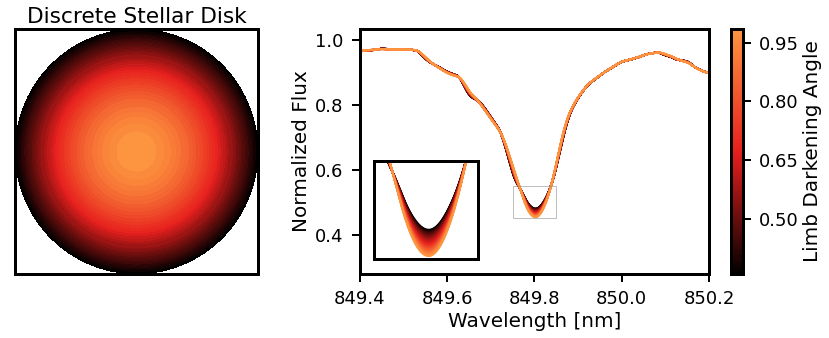

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4.5),
                               gridspec_kw={'width_ratios':[1,1.8]})


im = ax1.contourf(plotting_limb, 100, cmap=cm)
ax1.set_xticks([]);ax1.set_yticks([])


axins = ax2.inset_axes([0.04, 0.06, 0.3, 0.4])
axins.set_xticks([]);axins.set_yticks([])

for i in range(len(colors)):
    ax2.plot(tab['wavelength']/10, tab[tab.colnames[i+2]], c=colors[i],
             lw=2)
    axins.plot(tab['wavelength']/10, tab[tab.colnames[i+2]], c=colors[i],
             lw=2)

axins.set_xlim(849.75, 849.85)
axins.set_ylim(0.45,0.55)
ax2.indicate_inset_zoom(axins)
ax2.set_xlabel('Wavelength [nm]', fontsize=20)
ax2.set_ylabel('Normalized Flux', fontsize=20)
ax1.set_title('Discrete Stellar Disk')
ax2.set_xlim(849.4,850.2)
cbar = plt.colorbar(im)
cbar.set_label('Limb Darkening Angle', fontsize=20)
cbar.set_ticks(np.round(np.arange(0.35, 1.1, 0.15),2))

ax1.set_rasterized(True)
ax2.set_rasterized(True)

plt.subplots_adjust(wspace=0.3)
plt.savefig('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/clvs.pdf',
            rasterize=True, bbox_inches='tight', dpi=250)

# Making the movie

In [ ]:
plt.rcParams['font.size'] = 15

In [ ]:
for i in range(35,55):

    fig, (ax1, ax2) = plt.subplots(ncols=2, 
                                   gridspec_kw={'width_ratios':[1,1.8]},
                                   figsize=(12,4))

    ax1.imshow(discrete_limb, cmap='YlOrRd_r')
    ax1.imshow(all_masks[i], cmap='Greys_r')
    ax1.set_xticks([]); ax1.set_yticks([])
    
    med = spec_timesteps[i]/np.nanmedian(spec_timesteps[i])

    if i != 0 and i != len(tsteps)-1:
        diff = -1* (spec_timesteps[i] - template)
        ax2.plot(tab['wavelength'], 
                 diff/np.nanmedian(diff),
                 color='k', lw=4)
    else:
        ax2.plot(tab['wavelength'],
                 template/np.nanmedian(template),
                 color='k', lw=4)
   # ax2.plot(tab['wavelength'], 
   #              template/np.nanmedian(template), 
   #              color='k', lw=2)
    ax2.set_xlim(6561.8,6563.95)
    ax2.set_ylim(0.5,1.0)
    ax2.set_xlabel('Wavelength [nm]')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_xticks(np.round(np.linspace(6561.8,6563.95,4),2))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [ ]:
np.nanmedian(diff)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, 
                               gridspec_kw={'width_ratios':[1,1.8]},
                               figsize=(12,4))
# X is (Nt, Ny, Nx)
im = ax1.imshow(discrete_limb, cmap='YlOrRd_r')
fig.tight_layout()
ax1.set_xticks([]); ax1.set_yticks([])
ax2.set_xlim(6561.8,6563.95)
ax2.set_ylim(0.5,1.0)
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Normalized Flux')
ax2.set_xticks(np.round(np.linspace(6561.8,6563.95,4),2))


def animate(i):
    if i > 0:
        ax2.clear()
    ax1.imshow(discrete_limb, cmap='YlOrRd_r')
    ax1.imshow(all_masks[i], cmap='Greys_r')
    diff = -1* (spec_timesteps[i] - template)
    
    if np.nanmedian(diff) == 0:
        ax2.plot(tab['wavelength'],
                 template / np.nanmedian(template),
                 color='k', lw=3)
    else:
        ax2.plot(tab['wavelength'],
                     diff / np.nanmedian(diff),
                     color='k', lw=3)
    ax2.set_xlim(6561.8,6563.95)
    ax2.set_ylim(0.5,1.0)
    ax2.set_xlabel('Wavelength [nm]')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_xticks(np.round(np.linspace(6561.8,6563.95,4),2))
    return im,

#ax1.set_xticks([]); ax1.set_yticks([])

anim = FuncAnimation(fig, animate, 
                     frames=np.arange(0, len(all_masks), 1), 
                     blit=True, interval=60)
HTML(anim.to_jshtml())

In [ ]:
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
anim.save('/Users/arcticfox/Desktop/clv.mp4', writer=writer)